In [3]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import concatenate, Conv2D, Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Cropping2D
from keras.optimizers import Adam, Adamax, Nadam, Adadelta, SGD, RMSprop    
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.io_utils import HDF5Matrix
import h5py
import keras

from keras.layers.normalization import BatchNormalization
from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import shapely.wkt
import shapely.affinity
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
from keras.backend import binary_crossentropy
import tensorflow as tf

In [4]:
config = tf.ConfigProto()
print(config.gpu_options.allow_growth)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
keras.backend.set_session(sess)


False


In [5]:


Dir = '/home/yokoyang/Downloads/kaggle-data/EU'

train_img = pd.read_csv(Dir + '/data_imageID.csv')

Image_ID = sorted(train_img.ImageId.unique())
print(Image_ID)

N_split = 4

Patch_size = 192
crop_size = 224
edge_size = int((crop_size - Patch_size) / 2)
Class_Type = 1
# 1200 = 300 * 4
# size = 1024
Scale_Size = Patch_size * N_split
get_size = 80

['Amsterdam_0_0', 'Amsterdam_0_1', 'Amsterdam_0_2', 'Amsterdam_0_3', 'Amsterdam_0_4', 'Amsterdam_0_5', 'Amsterdam_0_6', 'Amsterdam_1_0', 'Amsterdam_1_1', 'Amsterdam_1_2', 'Amsterdam_1_3', 'Amsterdam_1_4', 'Amsterdam_1_5', 'Amsterdam_1_6', 'Amsterdam_2_0', 'Amsterdam_2_1', 'Amsterdam_2_2', 'Amsterdam_2_3', 'Amsterdam_2_4', 'Amsterdam_2_5', 'Amsterdam_2_6', 'Amsterdam_3_0', 'Amsterdam_3_1', 'Amsterdam_3_2', 'Amsterdam_3_3', 'Amsterdam_3_4', 'Amsterdam_3_5', 'Amsterdam_3_6', 'Amsterdam_4_0', 'Amsterdam_4_1', 'Amsterdam_4_2', 'Amsterdam_4_3', 'Amsterdam_4_4', 'Amsterdam_4_5', 'Amsterdam_4_6', 'Amsterdam_5_0', 'Amsterdam_5_1', 'Amsterdam_5_2', 'Amsterdam_5_3', 'Amsterdam_5_4', 'Amsterdam_5_5', 'Amsterdam_5_6', 'Berlin_0_0', 'Berlin_0_1', 'Berlin_0_2', 'Berlin_0_3', 'Berlin_0_4', 'Berlin_0_5', 'Berlin_0_6', 'Berlin_1_0', 'Berlin_1_1', 'Berlin_1_2', 'Berlin_1_3', 'Berlin_1_4', 'Berlin_1_5', 'Berlin_1_6', 'Berlin_2_0', 'Berlin_2_1', 'Berlin_2_2', 'Berlin_2_3', 'Berlin_2_4', 'Berlin_2_5', 'Berl

In [6]:
def get_mask(image_id):
    filename = os.path.join(
        Dir, 'land', '{}.tif'.format(image_id))
    msk = tiff.imread(filename)
    msk = msk.astype(np.float32) / 255
    msk = cv2.resize(msk, (Scale_Size, Scale_Size))
    msk_img = np.zeros([Scale_Size, Scale_Size], dtype=np.uint8)
    msk_img[:, :] = msk[:, :, 1]
    msk_img ^= 1
    return msk_img


def get_image(image_id):
    filename = os.path.join(
        Dir, 'satellite', '{}.tif'.format(image_id))
    img = tiff.imread(filename)
    img = img.astype(np.float32) / 255
    img_RGB = cv2.resize(img, (Scale_Size, Scale_Size))
    return img_RGB


def reflect_img(img):
    reflect = cv2.copyMakeBorder(img, int(edge_size), int(edge_size), int(edge_size), int(edge_size),
                                 cv2.BORDER_REFLECT)
    return reflect


def rotate_img(img, ang, size):
    rows = size
    cols = size
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 90 * ang, 1)
    dst = cv2.warpAffine(img, M, (cols, rows))
    return dst


def rotate_msk(msk, ang):
    return np.rot90(msk, ang)


def get_patch(img_id, pos=1):
    img_ = []
    msk_ = []
    img = get_image(img_id)
    img = reflect_img(img)
    mask = get_mask(img_id)
    for i in range(N_split):
        for j in range(N_split):
            y = mask[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0):
                x_start = int(Patch_size * i)
                x_end = int(Patch_size * (i + 1) + edge_size * 2)
                y_start = int(Patch_size * j)
                y_end = int(Patch_size * (j + 1) + edge_size * 2)
                x = img[x_start:x_end, y_start:y_end, :]
                # start rotate y and x
                rdm = random.uniform(-2, 5)
                if rdm > 1:
                    ang = rdm // 1
                    x = rotate_img(x, ang, crop_size)
                    y = rotate_msk(y, ang)
                    # print(x.shape)
                    # print(y.shape)

                img_.append(x)
                msk_.append(y[:, :, None])

    return img_, msk_


def get_all_patches(pos=1):
    img_all = []
    msk_all = []
    count = 0
    for img_id in Image_ID:
        img_, msk_ = get_patch(img_id, pos=pos)
        if len(msk_) > 0:
            count = count + 1
            if count == 1:
                img_all = img_
                msk_all = msk_
            else:
                img_all = np.concatenate((img_all, img_), axis=0)
                msk_all = np.concatenate((msk_all, msk_), axis=0)

    # if pos == 1:
    #     np.save(Dir + '/output/data_pos_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)
    #
    # else:
    #     np.save(Dir + '/output/data_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)

    return img_all, msk_all[:, :, :, 0]


def get_normalized_patches():
    img_all, msk_all = get_all_patches()
    #     data = np.load(Dir + '/output/data_pos_%d_%d_class%d.npy' % (Patch_size, N_split, Class_Type))
    img = img_all
    msk = msk_all
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std
    print(mean, std)
    print(np.mean(img), np.std(img))
    return img, msk


In [29]:
def get_unet_5():
    #     Patch_size = 224
    inputs = Input((crop_size, crop_size, 3))

    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    cropping_2d = Cropping2D(cropping=((edge_size, edge_size), (edge_size, edge_size)),
                             input_shape=(int(crop_size), int(crop_size), 3))(conv10)

    model = Model(inputs=inputs, outputs=cropping_2d)

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model





In [7]:
smooth = 1e-12

def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)


In [8]:
def get_unet0():
    #     Patch_size = 224
    inputs = Input((crop_size, crop_size, 3))

    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization(axis=1)(conv1)
    conv1 = keras.layers.advanced_activations.ELU()(conv1)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization(axis=1)(conv1)
    conv1 = keras.layers.advanced_activations.ELU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization(axis=1)(conv2)
    conv2 = keras.layers.advanced_activations.ELU()(conv2)    
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization(axis=1)(conv2)
    conv2 = keras.layers.advanced_activations.ELU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization(axis=1)(conv3)
    conv3 = keras.layers.advanced_activations.ELU()(conv3)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization(axis=1)(conv3)
    conv3 = keras.layers.advanced_activations.ELU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization(axis=1)(conv4)
    conv4 = keras.layers.advanced_activations.ELU()(conv4)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization( axis=1)(conv4)
    conv4 = keras.layers.advanced_activations.ELU()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization( axis=1)(conv5)
    conv5 = keras.layers.advanced_activations.ELU()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization(axis=1)(conv5)
    conv5 = keras.layers.advanced_activations.ELU()(conv5)
        
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization(axis=1)(conv6)
    conv6 = keras.layers.advanced_activations.ELU()(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization(axis=1)(conv6)
    conv6 = keras.layers.advanced_activations.ELU()(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization(axis=1)(conv7)
    conv7 = keras.layers.advanced_activations.ELU()(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization(axis=1)(conv7)
    conv7 = keras.layers.advanced_activations.ELU()(conv7)
    
    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization( axis=1)(conv8)
    conv8 = keras.layers.advanced_activations.ELU()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization(axis=1)(conv8)
    conv8 = keras.layers.advanced_activations.ELU()(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization(axis=1)(conv9)
    conv9 = keras.layers.advanced_activations.ELU()(conv9)    
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization(axis=1)(conv9)
    conv9 = keras.layers.advanced_activations.ELU()(conv9)
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    cropping_2d = Cropping2D(cropping=((edge_size, edge_size), (edge_size, edge_size)),
                             input_shape=(int(crop_size), int(crop_size), 3))(conv10)

    model = Model(inputs=inputs, outputs=cropping_2d)
    model.compile(optimizer=Nadam(lr=1e-3), loss=jaccard_coef_loss, metrics=['binary_crossentropy', jaccard_coef_int])
    # model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model





In [9]:
# In predicting testing dataset, need to use the same mean and std in preprocessing training data
def post_normalize_image(img, mean=0.48894683, std=0.2100344):
    img = (img - mean) / std
    return img


In [12]:
all_Image_ID = sorted(train_img.ImageId.unique())
all_len = len(all_Image_ID)
loop_time = all_len // get_size
last_weight = ''
loop_i = 0
for i in range(loop_time):
    Image_ID = random.sample(all_Image_ID, get_size)
    all_Image_ID = [Image_ID2 for Image_ID2 in all_Image_ID if Image_ID2 not in Image_ID]
    img, msk = get_normalized_patches()
    x_trn, x_val, y_trn, y_val = train_test_split(img, msk, test_size=0.2, random_state=42)
    y_trn = y_trn[:, :, :, None]
    y_val = y_val[:, :, :, None]

    model = get_unet0()
    if i != 0:
        print("loaded")
        model.load_weights(last_weight)

    check_point_file_name = str(loop_i) + '_rotate_val_jaccard_coef_int.hdf5'
    model_checkpoint = ModelCheckpoint(check_point_file_name, monitor='val_jaccard_coef_int', save_best_only=True,
                                       mode='max')
    # model_checkpoint = ModelCheckpoint(check_point_file_name, monitor='val_acc', save_best_only=True, mode='max')
    model.fit(x_trn, y_trn, batch_size=16, epochs=25, verbose=1, shuffle=True, callbacks=[model_checkpoint],
              validation_data=(x_val, y_val))
    last_weight = check_point_file_name
    loop_i += 1
    del x_trn, x_val, y_trn, y_val, model

img_last = all_len - loop_time * get_size
if img_last > 0:
    Image_ID = random.sample(all_Image_ID, img_last)
    print(len(Image_ID))

    all_Image_ID = [Image_ID2 for Image_ID2 in all_Image_ID if Image_ID2 not in Image_ID]

    img, msk = get_normalized_patches()
    x_trn, x_val, y_trn, y_val = train_test_split(img, msk, test_size=0.2, random_state=42)
    y_trn = y_trn[:, :, :, None]
    y_val = y_val[:, :, :, None]

    model = get_unet0()
    if loop_i != 0:
        print("loaded")
        model.load_weights(last_weight)
    # model.load_weights("1unet5_c1.hdf5")
    check_point_file_name = str(loop_i) + '_rotate_val_jaccard_coef_int.hdf5'
    model_checkpoint = ModelCheckpoint(check_point_file_name, monitor='val_jaccard_coef_int', save_best_only=True,
                                       mode='max')
    model.fit(x_trn, y_trn, batch_size=16, epochs=25, verbose=1, shuffle=True, callbacks=[model_checkpoint],
              validation_data=(x_val, y_val))
    last_weight = check_point_file_name


0.4836523 0.20943636


-1.3632422e-05 1.0000025


Train on 840 samples, validate on 210 samples
Epoch 1/25


In [10]:
def save_result_pic(filename, img):
    img = img.astype(np.uint8)
    img *= 255
    cv2.imwrite(filename, img)

In [11]:
def predict_id(img_id, model, th):
    img = get_image(img_id)
    img = post_normalize_image(img)
    print(img.shape)
    prd = np.zeros((Patch_size * N_split, Patch_size * N_split, 1)).astype(np.float32)

    for i in range(N_split):
        for j in range(N_split):
            x = img[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1), :]
            x = reflect_img(x)
            tmp = model.predict(x[None, :, :, :], batch_size=4)
            prd[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)] = tmp
    prd_result = prd > th
    return prd_result, prd


def check_predict(model, th, img_id=Image_ID[17], Class_Type=1):
    msk_prd, row = predict_id(img_id, model, th)
    print(row.shape)
    img = get_image(img_id)
    msk_prd = msk_prd[:, :, 0]
    msk = get_mask(img_id)
    plt.figure(figsize=[21, 8])

    plt.subplot(1, 3, 1)
    plt.title('Training Image')
    plt.imshow(img)
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite("img_result/train"+img_id+".tif", img2)

    plt.subplot(1, 3, 2)
    plt.title('Training Mask')
    plt.imshow(msk, cmap=plt.get_cmap('gist_ncar'))
    # cv2.imwrite("msk.tif", msk)
    save_result_pic("img_result/ground_truth"+img_id+".tif", msk)

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(msk_prd, cmap=plt.get_cmap('gist_ncar'))
    # cv2.imwrite("msk_prd.tif", msk_prd)
    print(msk_prd.max())
    plt.axis('off')
    plt.show()
    save_result_pic("img_result/msk_prd_1"+img_id+".tif", msk_prd)
    save_result_pic("img_result/msk_prd_2"+img_id+".tif", ~msk_prd)


In [14]:
Dir = '/home/yokoyang/Downloads/kaggle-data/EU2'

test_img = pd.read_csv(Dir + '/data_imageID.csv')

Image_ID = sorted(test_img.ImageId.unique())


In [20]:
def get_unet_6():
    #     Patch_size = 224
    inputs = Input((crop_size, crop_size, 3))

    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    #     drop5 = Dropout(0.5)(conv4)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool5)
    conv6 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    #     drop5 = Dropout(0.5)(conv5)

    up7 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv5, up7], axis=3)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv4, up8], axis=3)
    conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv3, up9], axis=3)
    conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    up10 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv9))
    merge10 = concatenate([conv2, up10], axis=3)
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge10)
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)

    up11 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv10))
    merge11 = concatenate([conv1, up11], axis=3)
    conv11 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge11)
    conv11 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv11)

    #     conv11 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv12 = Conv2D(1, 1, activation='sigmoid')(conv11)
    cropping_2d = Cropping2D(cropping=((edge_size, edge_size), (edge_size, edge_size)),
                             input_shape=(int(crop_size), int(crop_size), 3))(conv12)

    model = Model(inputs=inputs, outputs=cropping_2d)
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #     model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])
    #     model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])  
    #     model.compile(optimizer=Adamax(), loss='binary_crossentropy', metrics=['accuracy'])
    #     model.compile(optimizer=Adadelta(), loss='binary_crossentropy', metrics=['accuracy'])     

    return model


(768, 768, 3)


(768, 768, 1)
True


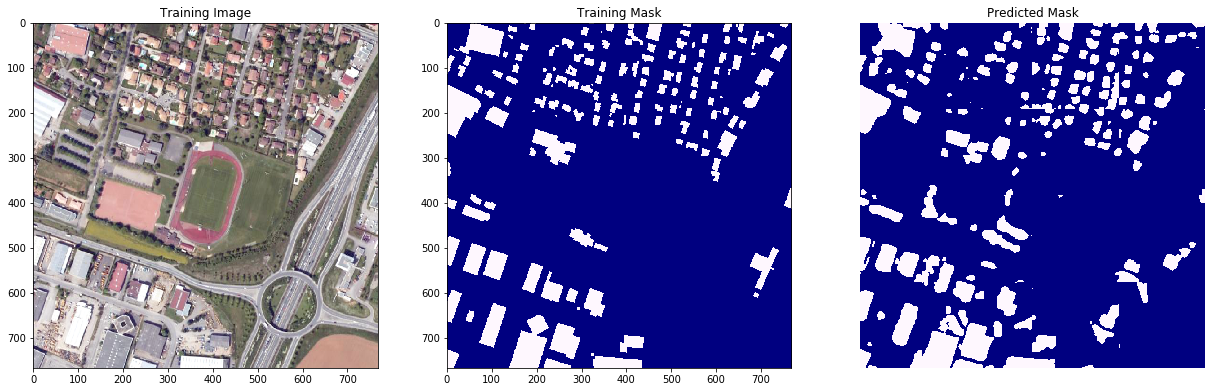

Lyon_1_0


In [34]:
model = get_unet0()
model.load_weights('1_rotate_val_jaccard_coef_int_2.hdf5')
img_id = Image_ID[7]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


(1024, 1024, 1)
True


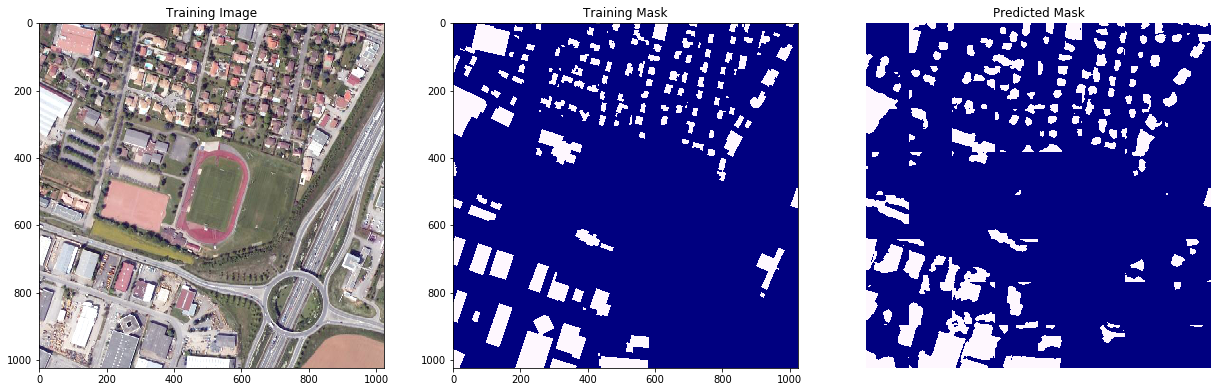

Lyon_1_0


In [40]:
model = get_unet0()
model.load_weights('1_rotate_val_jaccard_coef_int.hdf5')
img_id = Image_ID[7]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(768, 768, 3)


(768, 768, 1)
True


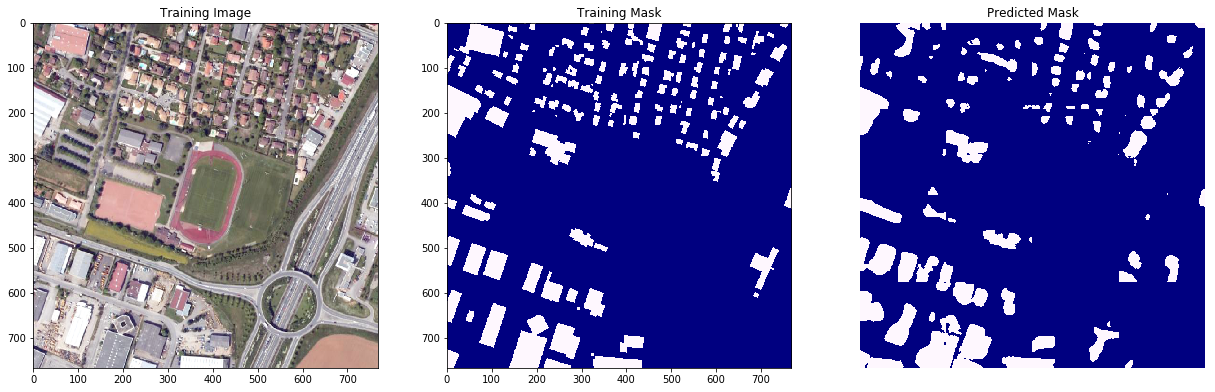

Lyon_1_0


In [31]:
model = get_unet_5()
model.load_weights('1_unet5_c1_rotate.hdf5')
img_id = Image_ID[7]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(768, 768, 3)


(768, 768, 1)
True


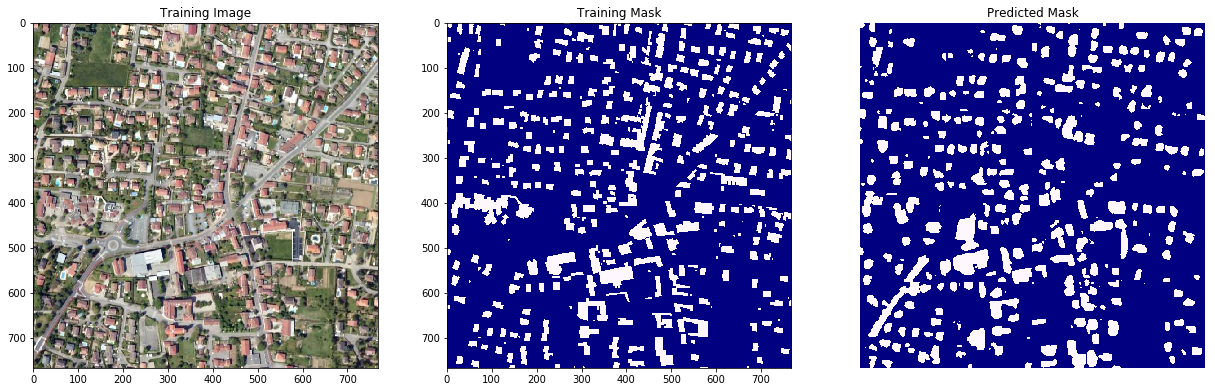

Lyon_0_5


In [25]:
img_id = Image_ID[5]
model = get_unet0()
model.load_weights('1_rotate_val_jaccard_coef_int_2.hdf5')
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)

(1024, 1024, 3)


(1024, 1024, 1)
True


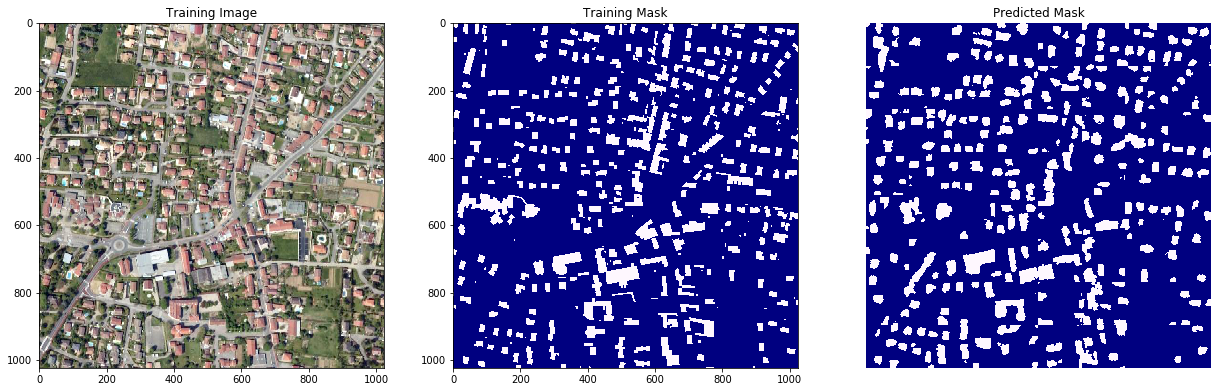

Lyon_0_5


In [42]:
model = get_unet0()
model.load_weights('1_rotate_val_jaccard_coef_int.hdf5')
img_id = Image_ID[5]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


(1024, 1024, 1)
True


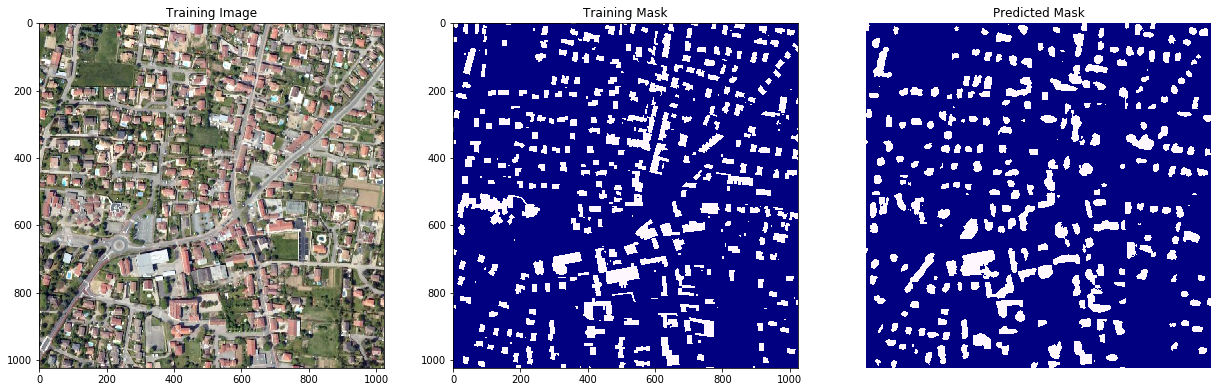

Lyon_0_5


In [30]:
model = get_unet_5()
model.load_weights('1_unet5_c1_rotate.hdf5')
img_id = Image_ID[5]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(768, 768, 3)


(768, 768, 1)
True


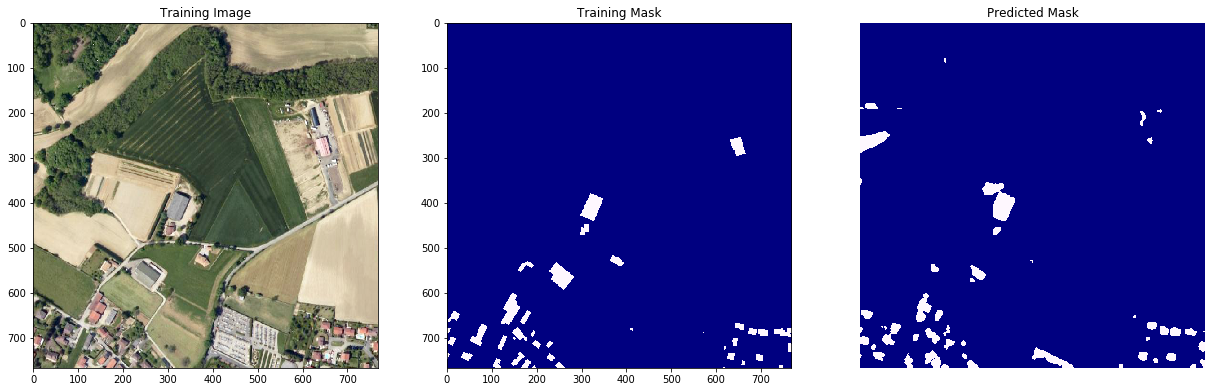

Lyon_0_3


In [23]:
img_id = Image_ID[3]
model = get_unet0()
model.load_weights('1_rotate_val_jaccard_coef_int_2.hdf5')
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)

(1024, 1024, 3)


(1024, 1024, 1)
True


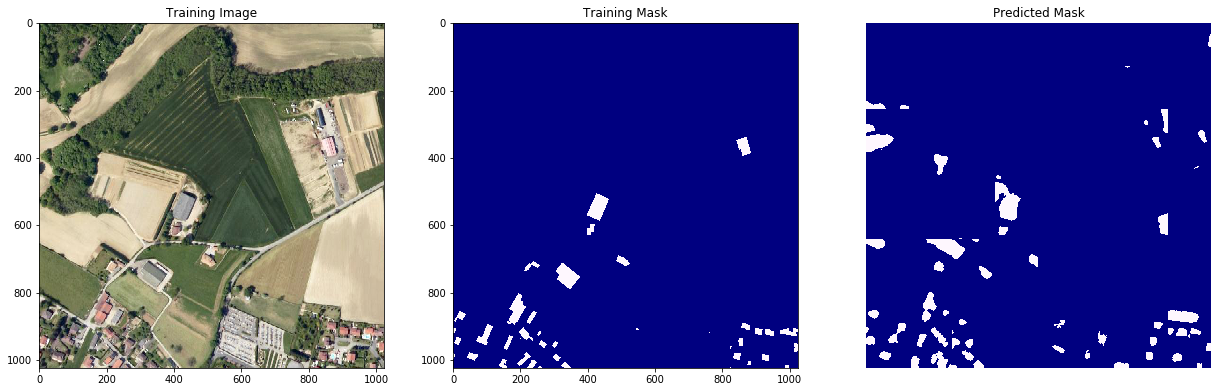

Lyon_0_3


In [38]:
model = get_unet0()
model.load_weights('1_rotate_val_jaccard_coef_int.hdf5')
img_id = Image_ID[3]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


(1024, 1024, 1)
True


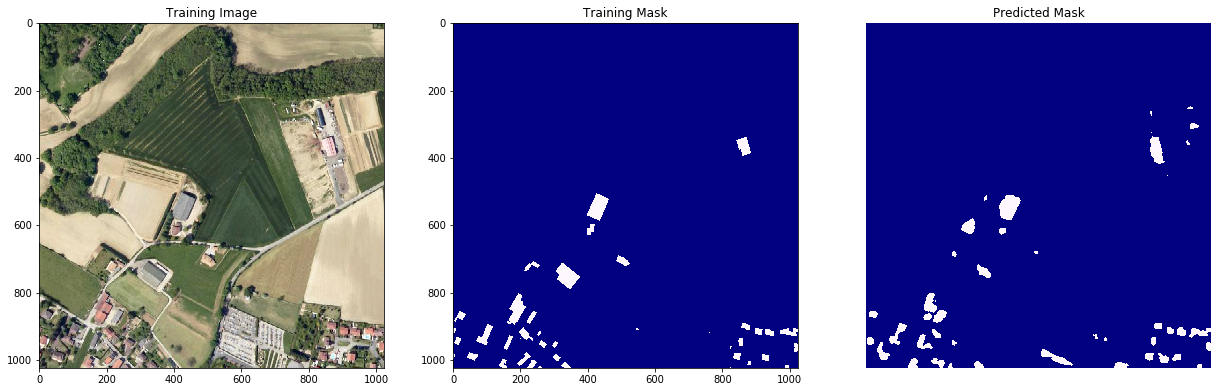

Lyon_0_3


In [31]:
model = get_unet_5()
model.load_weights('1_unet5_c1_rotate.hdf5')
img_id = Image_ID[3]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(768, 768, 3)


(768, 768, 1)
True


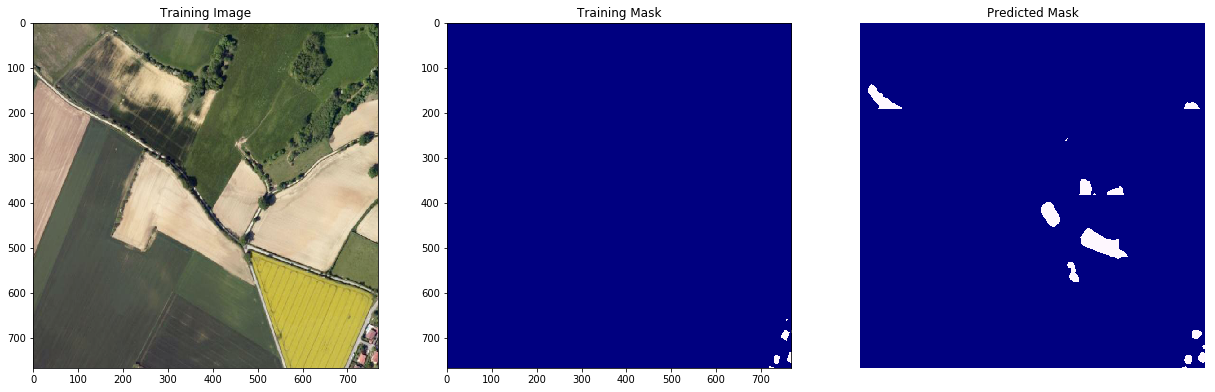

Lyon_0_2


In [22]:
img_id = Image_ID[2]
model = get_unet0()
model.load_weights('1_rotate_val_jaccard_coef_int_2.hdf5')
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)

(1024, 1024, 3)


(1024, 1024, 1)
True


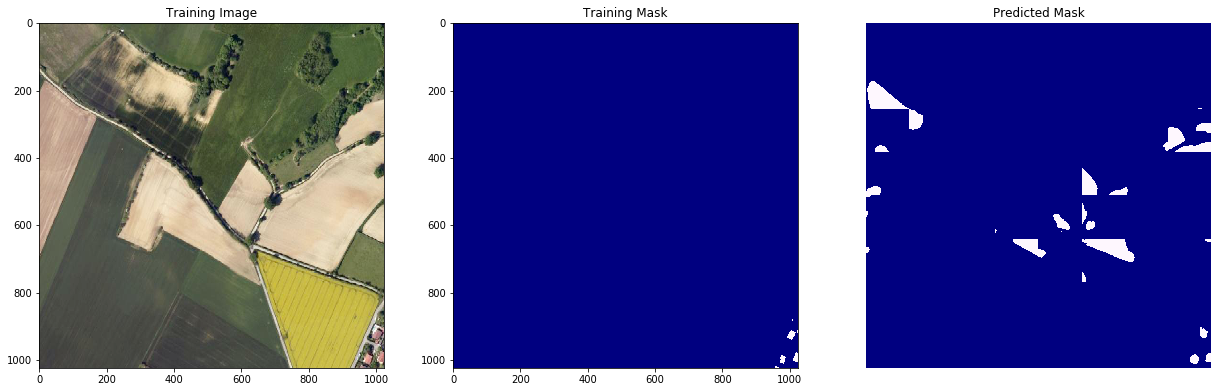

Lyon_0_2


In [36]:
model = get_unet0()
model.load_weights('1_rotate_val_jaccard_coef_int.hdf5')
img_id = Image_ID[2]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


True


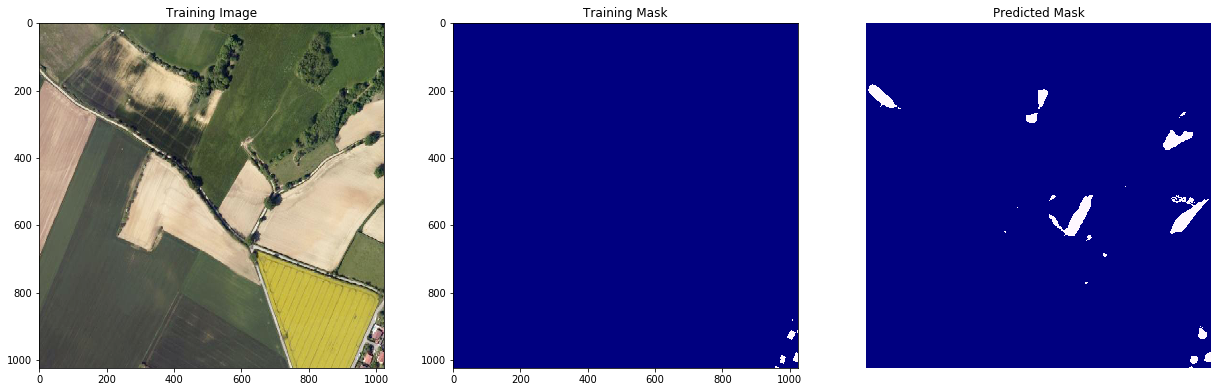

Lyon_0_2


In [16]:
model = get_unet_5()
model.load_weights('1_unet5_c1.hdf5')
img_id = Image_ID[2]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


(1024, 1024, 1)
True


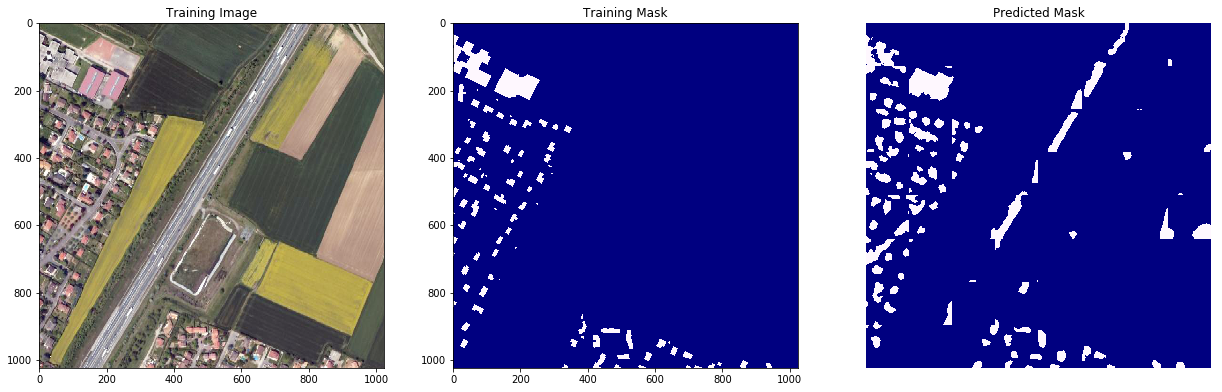

Lyon_0_1


In [34]:
model = get_unet0()
model.load_weights('1_rotate_val_jaccard_coef_int.hdf5')
img_id = Image_ID[1]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


True


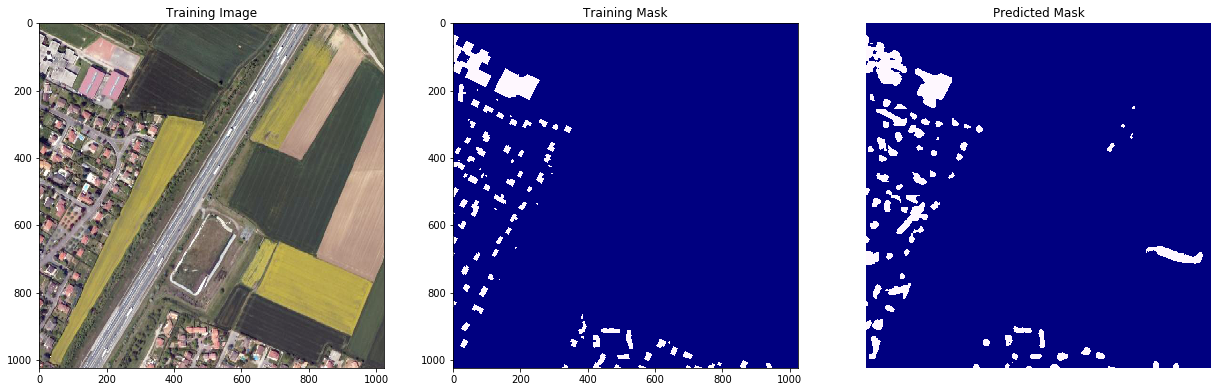

Lyon_0_1


In [45]:
model = get_unet_5()
model.load_weights('1_unet5_c1_rotate.hdf5')
img_id = Image_ID[1]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


True


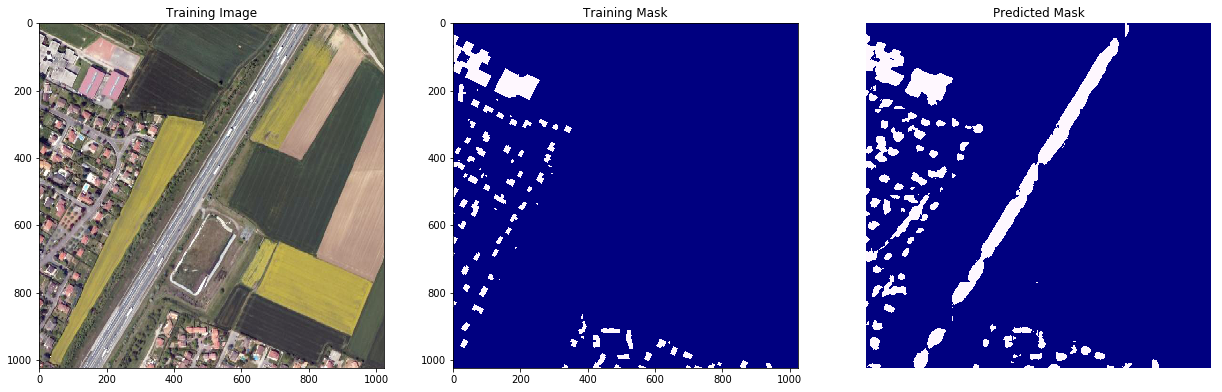

Lyon_0_1


In [17]:
model = get_unet_5()
model.load_weights('1_unet5_c1.hdf5')
img_id = Image_ID[1]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(768, 768, 3)


(768, 768, 1)
True


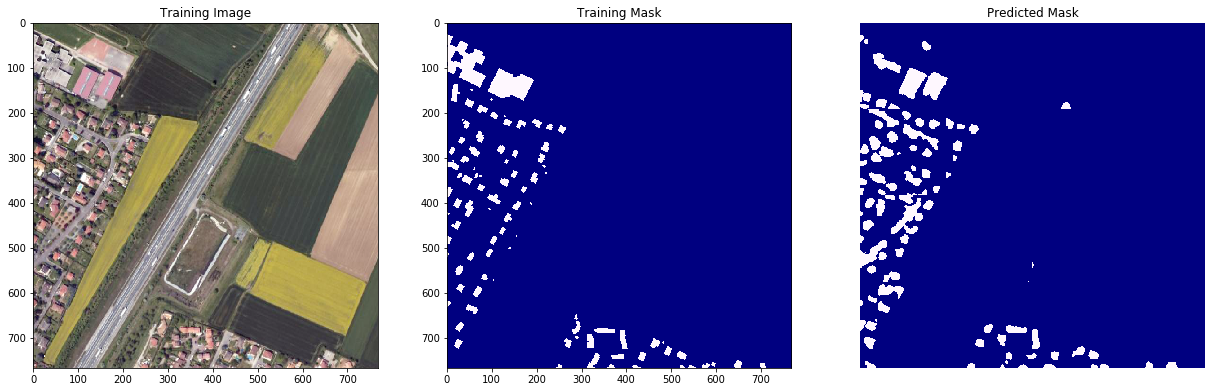

Lyon_0_1


In [26]:
model = get_unet0()
model.load_weights('1_rotate_val_jaccard_coef_int_2.hdf5')
img_id = Image_ID[1]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)